In [1]:
print("Hello World")

Hello World


In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install scikit-image

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd

# Load the CSV file
file_path = '/root/ubc/train.csv'
train_data = pd.read_csv(file_path)

# Displaying the first few rows of the dataframe for an overview
train_data['label'].unique()

array(['HGSC', 'LGSC', 'EC', 'CC', 'MC'], dtype=object)

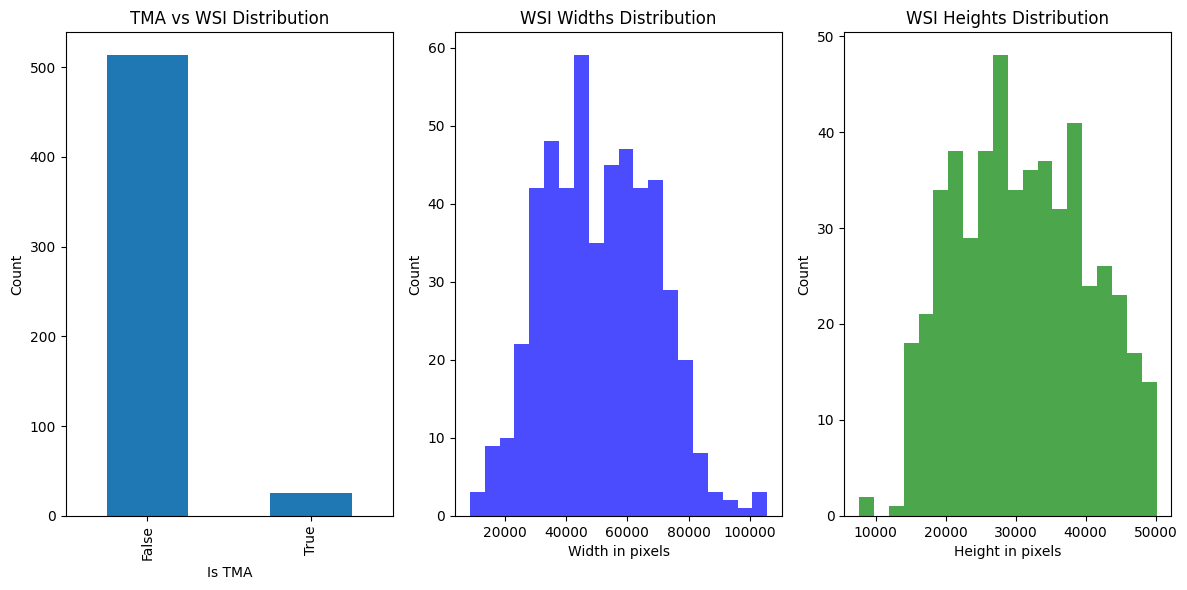

In [4]:
import matplotlib.pyplot as plt

# Analyzing the distribution of TMA vs WSI images
tma_wsi_counts = train_data['is_tma'].value_counts()

# Analyzing the distribution of image widths and heights for WSI images
wsi_data = train_data[train_data['is_tma'] == False]
wsi_widths = wsi_data['image_width']
wsi_heights = wsi_data['image_height']

# Plotting
plt.figure(figsize=(12, 6))

# Plot for TMA vs WSI distribution
plt.subplot(1, 3, 1)
tma_wsi_counts.plot(kind='bar')
plt.title('TMA vs WSI Distribution')
plt.xlabel('Is TMA')
plt.ylabel('Count')

# Plot for WSI Widths Distribution
plt.subplot(1, 3, 2)
plt.hist(wsi_widths, bins=20, color='blue', alpha=0.7)
plt.title('WSI Widths Distribution')
plt.xlabel('Width in pixels')
plt.ylabel('Count')

# Plot for WSI Heights Distribution
plt.subplot(1, 3, 3)
plt.hist(wsi_heights, bins=20, color='green', alpha=0.7)
plt.title('WSI Heights Distribution')
plt.xlabel('Height in pixels')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


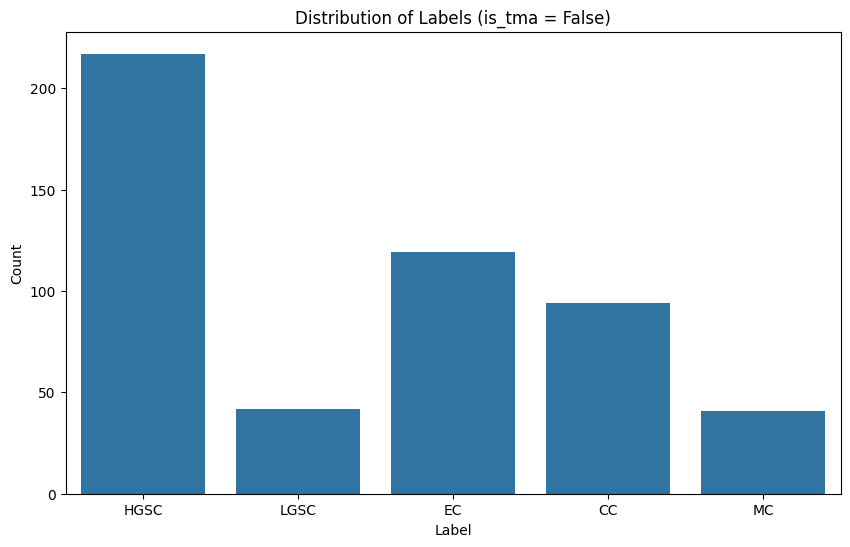

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming train_data is a pandas DataFrame and 'label' is a column in it
# Filtering the DataFrame for rows where 'is_tma' is False
filtered_data = train_data[train_data['is_tma'] == False]

# Plotting the distribution of 'label' values in the filtered data
plt.figure(figsize=(10, 6))
sns.countplot(data=filtered_data, x='label')
plt.title('Distribution of Labels (is_tma = False)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()


In [6]:
print("HGSC:",len(wsi_data[wsi_data['label'] == 'HGSC']), "LGSC:",len(wsi_data[wsi_data['label'] == 'LGSC']),"EC:",len(wsi_data[wsi_data['label'] == 'EC']), "CC:",len(wsi_data[wsi_data['label'] == 'CC']),"MC:", len(wsi_data[wsi_data['label'] == 'MC']))

HGSC: 217 LGSC: 42 EC: 119 CC: 94 MC: 41


In [14]:
import pandas as pd
import random

# Load your train data
train_data = pd.read_csv('/root/ubc/train.csv')  # Replace with your actual train.csv file path

# Filter out the WSI images (is_tma == False) from the train.csv data
wsi_data = train_data[train_data['is_tma'] == False]

# Distribution of your WSI image data
distribution = {
    "HGSC": 217, 
    "LGSC": 42, 
    "EC": 119, 
    "CC": 94, 
    "MC": 20
}

# Minimum number across classes to ensure a balanced dataset
min_samples = min(distribution.values())

# Function to randomly select 'min_samples' from each category
def random_sample_group(group):
    return group.sample(n=min_samples)

# Group by label and apply the sampling function
balanced_sample = wsi_data.groupby('label').apply(random_sample_group).reset_index(drop=True)

# Save the sampled data to a CSV file
output_csv_path = '/root/ubc_ocean/alper/wsi_equally.csv'  # Replace with your desired path
balanced_sample.to_csv(output_csv_path, index=False)

print(f"Balanced sample CSV file saved to: {output_csv_path}")

Balanced sample CSV file saved to: /root/ubc_ocean/alper/wsi_equally.csv


In [17]:
balanced_sample

,image_id,label,image_width,image_height,is_tma
0,38669,CC,41105,27185,False
1,29915,CC,68112,33540,False
2,36063,CC,83724,35889,False
3,43796,CC,70772,36940,False
4,44976,CC,67671,23860,False
...,...,...,...,...,...
95,30986,MC,66911,49395,False
96,37307,MC,46120,39107,False
97,23523,MC,74723,45387,False
98,39252,MC,48980,40700,False


In [ ]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Import matplotlib.pyplot for displaying patches

wsi_data = pd.read_csv("/root/ubc_ocean/alper/wsi_equally.csv")
# Path to the zip file and the directory where extracted images will be stored
zip_file_path = '/root/UBC-OCEAN.zip'  # Replace with the actual path
temp_extract_dir = '/root/ubc_ocean/alper/'  # Replace with the desired path

# Assuming train_data is your DataFrame from train.csv
# Filtering out the WSI images from the train.csv data
wsi_image_ids = wsi_data[wsi_data['is_tma'] == False]['image_id'].tolist()


def extract_features(image):
    # Example feature extraction: using color histograms
    # You can replace this with a more sophisticated feature extraction method
    hist = cv2.calcHist([image], [0, 1, 2], None, [256, 256, 256], [0, 256, 0, 256, 0, 256])
    return hist.flatten()


def extract_tissue_patches(image_path, patch_size=256, tissue_threshold=0.5, black_threshold=50):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    height, width, _ = image.shape

    features_list = []

    # Pre-calculate the number of pixels that can be considered black
    black_pixel_count_threshold = patch_size * patch_size * black_threshold

    # Iterate over the image with a sliding window
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            # Extract the patch
            patch = image[y:y + patch_size, x:x + patch_size]

            # Skip if the patch is smaller than the patch size (at the borders)
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue

            # Check if the patch is mostly black and skip it if so
            if np.sum(patch < black_threshold) >= black_pixel_count_threshold:
                continue

            # Tissue detection logic here
            tissue_percentage = np.sum(np.mean(patch, axis=2) < 235) / (patch_size * patch_size)

            # If the patch contains more than the threshold of tissue, process it
            if tissue_percentage > tissue_threshold:
                print(f"Processing patch at [{x}, {y}] in {image_path}")

                # Show the patch using matplotlib
                plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
                plt.show()

                # Extract features from the patch
                features = extract_features(patch)
                features_list.append(features)

    return np.array(features_list)

# Function to extract, print path, and then remove each WSI image
def process_each_image(zip_path, temp_dir, image_ids):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for image_id in image_ids:
            # Construct the file name based on the image ID
            internal_zip_path = f"train_images/{image_id}.png"  # Adjust the file extension if needed
            print(image_id)
            print(internal_zip_path)
            # Full path for the extracted image inside the temporary directory
            extracted_image_path = os.path.join(temp_dir, internal_zip_path)

            # Check if the file exists in the zip file
            if internal_zip_path in zip_ref.namelist():
                # Extract the image
                zip_ref.extract(internal_zip_path, temp_dir)

                # Print the path of the extracted image
                print(f"Extracted and processing: {extracted_image_path}")

                # Process the image (add your processing code here)
                try:
                    extract_tissue_patches(extracted_image_path)
                except Exception as e:
                    print(f"Error processing image: {e}")

                # Remove the extracted image to free up space
                os.remove(extracted_image_path)
                print(f"Removed: {extracted_image_path}")

                # Release memory occupied by the image and patches
                del image
                cv2.destroyAllWindows()
            else:
                print(f"Image ID {image_id} not found in the zip file.")


# def extract_tissue_patches(image_path, patch_size=256, tissue_threshold=0.5, black_threshold=50):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Image at {image_path} could not be loaded.")
    
    height, width, _ = image.shape

    features_list = []

    # Pre-calculate the number of pixels that can be considered black
    black_pixel_count_threshold = patch_size * patch_size * black_threshold

    # Iterate over the image with a sliding window
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            # Extract the patch
            patch = image[y:y + patch_size, x:x + patch_size]

            # Skip if the patch is smaller than the patch size (at the borders)
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                continue

            # Check if the patch is mostly black and skip it if so
            if np.sum(patch < black_threshold) >= black_pixel_count_threshold:
                continue

            # Tissue detection logic here
            tissue_percentage = np.sum(np.mean(patch, axis=2) < 235) / (patch_size * patch_size)

            # If the patch contains more than the threshold of tissue, process it
            if tissue_percentage > tissue_threshold:
                print(f"Processing patch at [{x}, {y}] in {image_path}")

                # Show the patch using matplotlib
                plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))
                plt.show()

                # Extract features from the patch
                features = extract_features(patch)
                features_list.append(features)

    return np.array(features_list)


# Function to extract, print path, and then remove each WSI image
def process_each_image(zip_path, temp_dir, image_ids):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for image_id in image_ids:
            # Construct the file name based on the image ID
            internal_zip_path = f"train_images/{image_id}.png"  # Adjust the file extension if needed
            print(image_id)
            print(internal_zip_path)
            # Full path for the extracted image inside the temporary directory
            extracted_image_path = os.path.join(temp_dir, internal_zip_path)

            # Check if the file exists in the zip file
            if internal_zip_path in zip_ref.namelist():
                # Extract the image
                zip_ref.extract(internal_zip_path, temp_dir)

                # Print the path of the extracted image
                print(f"Extracted and processing: {extracted_image_path}")

                # Process the image (add your processing code here)

                extract_tissue_patches(extracted_image_path)

                # Remove the extracted image to free up space
                os.remove(extracted_image_path)
                print(f"Removed: {extracted_image_path}")
            else:
                print(f"Image ID {image_id} not found in the zip file.")

# Call the function to process each image
process_each_image(zip_file_path, temp_extract_dir, wsi_image_ids)

In [1]:
import requests
from bs4 import BeautifulSoup

def get_html_content(url):
    response = requests.get(url)
    return response.text

# Example usage
url = 'https://tma.im/cgi-bin/viewAvailableStains.pl?array_block_name=TA-19'
html_content = get_html_content(url)

# Printing the HTML content
print(html_content)


<!DOCTYPE html
	PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN"
	 "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">
<html xmlns="http://www.w3.org/1999/xhtml" lang="en-US" xml:lang="en-US">
<head>
<title>TMAD View Stains and Scores for TA-19</title>
<meta name="description" content="TMAD, the Stanford Tissue Microarray database, stores raw
	    and normalized data from tissue microarray experiments, and
	    provides data retrieval, analysis and visualization
	    interfaces. Data is released to the public upon
	    publication." />
<meta name="keywords" content="bioinformatics, tissue microarray, functional
	    genomics, data mining, histology, TMA software,
	    datamining, pathology informatics, data analysis" />
<link href="/favicon.ico" rel="icon" type="image/ico" />
<link href="/favicon.ico" rel="shortcut icon" />
<link rel="stylesheet" type="text/css" href="/style.css" />
<meta http-equiv="Content-Type" content="text/html; charset=utf-8" />
</head>
<body>
<div class="h

In [2]:
import requests
from bs4 import BeautifulSoup

def print_image_urls(url):
    """
    Fetch the HTML content from the given URL and print the image URLs.
    """
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all image tags and print their 'src' attributes
    for img in soup.find_all('img'):
        print(img.get('src'))

# Example usage
url = 'https://tma.im/cgi-bin/viewAvailableStains.pl?array_block_name=TA-19'
print_image_urls(url)


/images/header.gif


In [ ]:
import requests
from bs4 import BeautifulSoup

def download_fullsize_images(page_url):
    # Send request to the page with the thumbnails
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # Find all thumbnail images or their containers
    thumbnails = soup.find_all('img')  # or whatever tag/class/id contains the thumbnail

    for thumbnail in thumbnails:
        # Extract the onclick or href attribute that contains the full-size image URL
        # This step is highly dependent on how the website is structured
        # You may need to simulate a click or extract the URL directly if it's available
        onclick_attribute = thumbnail.get('onclick')  # or 'href' or another attribute
        
        # Use a regular expression or string manipulation to extract the URL
        # This is just a placeholder, you would need to adjust the pattern to match the actual attribute content
        fullsize_image_url = extract_url_from_onclick(onclick_attribute)

        # Download the full-size image
        image_response = requests.get(fullsize_image_url)
        if image_response.status_code == 200:
            # Write the image to a file
            with open(fullsize_image_url.split('/')[-1], 'wb') as file:
                file.write(image_response.content)

def extract_url_from_onclick(onclick_str):
    # Use regular expressions or other string manipulation to extract the URL
    # This is just an example and will not work without the actual structure
    url_pattern = "window.open('YOUR_REGEX_PATTERN_HERE')"
    # Extract the URL here and return it
    return extracted_url

# Replace with the actual URL of the page with thumbnails
page_url = 'https://tma.im/cgi-bin/viewStain.pl?stain_no=702&view=Printable'
download_fullsize_images(page_url)

In [8]:
import requests
from bs4 import BeautifulSoup
import os

# Base URL for resolving relative links
base_url = 'https://tma.im'

def download_images_from_page(page_url):
    # Send a request to the page
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all the thumbnail containers
    thumb_containers = soup.find_all('td', class_='thumb')
    
    for container in thumb_containers:
        # Extract the full-size image link
        full_image_link = container.find('a')['href']
        
        # Make sure it's an absolute URL
        if not full_image_link.startswith('http'):
            full_image_link = base_url + full_image_link
        
        # Get the image content
        image_response = requests.get(full_image_link)
        
        if image_response.status_code == 200:
            # Extract the image name from the URL
            image_name = full_image_link.split('/')[-1]
            
            # Define a path to save the image
            image_path = os.path.join('/root/ubc_ocean/alper/external_tmas', image_name)
            
            # Save the image to the disk
            with open(image_path, 'wb') as image_file:
                image_file.write(image_response.content)
            print(f'Downloaded: {image_name}')
        else:
            print(f'Failed to download image: {full_image_link}')

# URL of the page with the images
images_page_url = 'https://tma.im/cgi-bin/selectImages.pl?antibody=he'

# Call the function to start downloading images
download_images_from_page(images_page_url)


In [9]:
import requests
from bs4 import BeautifulSoup
import os

# Base URL for resolving relative links
base_url = 'https://tma.im'

def download_images_from_divs(page_url, save_dir):
    # Send a request to the page
    response = requests.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find all divs that contain the images
    image_divs = soup.find_all('div', class_='iDiv0')
    
    # Ensure the directory exists
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Loop through all divs and download images
    for div in image_divs:
        # Find the link to the full-size image
        image_url = div.find('a')['href']
        
        # Make sure it's an absolute URL
        if not image_url.startswith('http'):
            image_url = base_url + image_url
        
        # Download the image
        image_response = requests.get(image_url)
        
        if image_response.status_code == 200:
            # Extract the image name from the URL
            image_name = os.path.basename(image_url)
            
            # Define the path to save the image
            image_path = os.path.join(save_dir, image_name)
            
            # Write the image to a file
            with open(image_path, 'wb') as image_file:
                image_file.write(image_response.content)
            print(f'Downloaded: {image_name}')
        else:
            print(f'Failed to download image: {image_url}')

# URL of the page with the images
images_page_url = 'https://tma.im/cgi-bin/selectImages.pl?antibody=apod'

# Directory to save the images
save_directory = '/root/ubc_ocean/alper/external_tmas/'  # Change this to the desired path

# Run the function to start downloading images
download_images_from_divs(images_page_url, save_directory)


Downloaded: 3_34_4_5_42_1128_930f16a94435ac2a82251f9d3d4850353a91a94328b15b5c36eac7b55fa55acb.jpg
Downloaded: 3_34_5_5_42_1128_b8a67ab92c76c8db55490325c3dbab8e346ef2522e0d8ebba1f799bdddc0b0f9.jpg
Downloaded: 1_34_7_1_42_1128_98e8208dc8007075e0c021e9f4abbd890a5f5747ef3f85c10fddabe881ff2506.jpg
Downloaded: 1_35_7_1_35_1128_1eb469d8bcbac399133c2dc9c5936b3f9cfaede173ff15de9199901a0433f618.jpg
Downloaded: 1_34_8_1_42_1128_2433c6f95d6b5f05e581f38021f47caeff7a09312f3d41419e770b6e64882395.jpg
Downloaded: 1_35_8_1_35_1128_90620d775aed96d456e5feb006d8f9f515332e3c46b5f3daf875a0e8097b057d.jpg
Downloaded: 2_34_6_3_42_1128_d58c59aefd048113ff2999ce6c20bf15070dd0654c1c4c5b37468c361024b40b.jpg
Downloaded: 2_34_7_3_42_1128_4abae86ae1f873cdf4204473efb90d876ace7e354e337a0bbcfe77a5db66a304.jpg
Downloaded: 4_35_2_5_35_1128_f2840e7912e82a5feace61a4591d27b8dc7a52530c7bb79008425f4e378a69e4.jpg
Downloaded: 4_35_3_5_35_1128_fe5d22c076cfbf43937aaae33d21639e6ef53500707a60216fc06eb1980673e5.jpg
Downloaded: 2_35_3_6

In [17]:
import requests
from bs4 import BeautifulSoup
import os

# Function to download images from a single page
def download_images_from_page(session, base_url, page_url, save_dir):
    print(f"Fetching images from {page_url}")
    response = session.get(page_url)
    soup = BeautifulSoup(response.content, 'html.parser')
    image_divs = soup.find_all('div', class_='iDiv0')
    
    for div in image_divs:
        image_url = base_url + div.find('a')['href']
        print(f"Downloading image from {image_url}")
        image_response = session.get(image_url)
        if image_response.status_code == 200:
            image_name = image_url.split('/')[-1]
            image_path = os.path.join(save_dir, image_name)
            with open(image_path, 'wb') as f:
                f.write(image_response.content)
            print(f"Downloaded: {image_name}")
        else:
            print(f"Failed to download image from {image_url}")

# Function to navigate pages and download images
def navigate_and_download(session, base_url, initial_url, save_dir):
    current_page = 1
    while True:
        page_url = f"{initial_url}&page={current_page}"
        print(f"Navigating to page {current_page}")
        download_images_from_page(session, base_url, page_url, save_dir)
        
        # Check if this is the last page
        response = session.get(page_url)
        soup = BeautifulSoup(response.content, 'html.parser')
        if soup.find('input', {'value': 'next 25 small images'}):
            current_page += 1
            print(f"Moving to the next page: {current_page}")
        else:
            print(f"No 'next' button found. Assuming we've reached the last page: {current_page}")
            break  # Stop if no next page button is found
        

# Main execution
session = requests.Session()
base_url = 'https://tma.im'
gallery_links = ['cgi-bin/selectImages.pl?antibody=20q13.2-RP4-724E16']
save_dir = '/root/ubc_ocean/alper/external_tmas/'  # Replace with the actual directory path

for link in gallery_links:
    gallery_url = base_url + '/' + link
    print(f"Starting download for gallery: {link}")
    navigate_and_download(session, base_url, gallery_url, save_dir)


Starting download for gallery: cgi-bin/selectImages.pl?antibody=20q13.2-RP4-724E16
Navigating to page 1
Fetching images from https://tma.im/cgi-bin/selectImages.pl?antibody=20q13.2-RP4-724E16&page=1
Downloaded: 1_239_4_3_118_999_28.jpg
Downloaded: 3_239_11_7_118_999_72.jpg
Downloaded: 1_239_11_7_118_999_77.jpg
Downloaded: 1_239_1_2_118_999_6.jpg
Downloaded: 1_239_1_3_118_999_5.jpg
Downloaded: 1_239_1_4_118_999_4.jpg
Downloaded: 1_239_1_5_118_999_3.jpg
Downloaded: 1_239_1_7_118_999_2.jpg
Downloaded: 1_239_10_2_118_999_74.jpg
Downloaded: 1_239_10_3_118_999_73.jpg
Downloaded: 1_239_10_4_118_999_72.jpg
Downloaded: 1_239_10_5_118_999_71.jpg
Downloaded: 1_239_10_6_118_999_70.jpg
Downloaded: 1_239_10_7_118_999_69.jpg
Downloaded: 1_239_11_3_118_999_81.jpg
Downloaded: 1_239_11_4_118_999_80.jpg
Downloaded: 1_239_11_5_118_999_79.jpg
Downloaded: 1_239_11_6_118_999_78.jpg
Downloaded: 1_239_11_8_118_999_76.jpg
Downloaded: 1_239_12_3_118_999_89.jpg
Downloaded: 1_239_12_4_118_999_88.jpg
Downloaded: 1_

KeyboardInterrupt: 

In [19]:
pip install selenium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 21.9 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.3/448.3 kB 3.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: sniffio
    Found existing installation: sniffio 1.2.0
    Uninstalling sniffio-1.2.0:
      Successfully uninstalled sniffio-1.2.0
Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException
import requests
from pathlib import Path
import traceback

service = Service(executable_path=ChromeDriverManager().install())
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(service=service, options=options)

def download_images(driver, base_url, download_path):
    try:
        images = driver.find_elements(By.CSS_SELECTOR, 'div.iDiv0 a')
        print(f"Found {len(images)} images on the page.")
        for image in images:
            image_url = image.get_attribute('href')
            print(f"Downloading: {image_url}")

            response = requests.get(image_url)
            if response.status_code == 200:
                file_name = image_url.split('/')[-1]
                file_path = Path(download_path) / file_name
                with open(file_path, 'wb') as file:
                    file.write(response.content)
                print(f"Saved: {file_path}")
    except Exception as e:
        print(f"Error during image download: {e}")
        traceback.print_exc()

def navigate_and_download(driver, initial_url, download_path):
    try:
        print(f"Navigating to URL: {initial_url}")
        driver.get(initial_url)
        while True:
            print("Checking for images...")
            download_images(driver, base_url, download_path)

            try:
                print("Looking for next button...")
                next_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.NAME, 'next 25 small images'))
                )
                next_button.click()

                print("Waiting for next set of images...")
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, 'div.iDiv0'))
                )
            except TimeoutException:
                print("Reached the last page or encountered a timeout.")
                break
    except Exception as e:
        print(f"An error occurred: {e}")
        traceback.print_exc()

base_url = 'https://tma.im'
initial_url = base_url + '/cgi-bin/selectImages.pl?antibody=apod'
download_path = "/root/ubc_ocean/alper/External_tmas/"
navigate_and_download(driver, initial_url, download_path)

driver.quit()

In [70]:
arr = ["ACTG2","agr2","ar","bcl1","BCL2","bcl2","bcl6","caldesmon","cam52","casq2","CATHEPSIN-L","cd10","cd117","cd117asISH","CD137","cd137l","CD16","cd163","CD183","CD2","cd20","CD20","CD29","CD3","cd3","CD30","CD32","cd34","CD43","cd44"]

In [73]:
len(arr)/142 * 70000

14788.732394366198

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.common.exceptions import TimeoutException
import requests
from pathlib import Path
import traceback

service = Service(executable_path=ChromeDriverManager().install())
options = webdriver.ChromeOptions()
options.add_argument('--headless')
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
driver = webdriver.Chrome(service=service, options=options)

def download_images(driver, download_path):
    images = driver.find_elements(By.CSS_SELECTOR, 'div.iDiv0 a')
    print(f"Found {len(images)} images on the page.")
    for image in images:
        image_url = image.get_attribute('href')
        file_name = image_url.split('/')[-1]
        file_path = Path(download_path) / file_name

        # Check if file already exists
        if file_path.exists():
            print(f"File {file_name} already exists. Moving to next antibody.")
            return False  # Indicates that the file already exists

        try:
            print(f"Downloading: {image_url}")
            response = requests.get(image_url)
            if response.status_code == 200:
                with open(file_path, 'wb') as file:
                    file.write(response.content)
                print(f"Saved: {file_path}")
        except Exception as e:
            print(f"Error during image download: {e}")
            traceback.print_exc()
    return True  # Indicates successful download of images

def navigate_and_download(driver, base_url, antibody, main_download_path):
    initial_url = f"{base_url}/cgi-bin/selectImages.pl?antibody={antibody}"
    download_path = Path(main_download_path) / antibody

    # Create directory if it doesn't exist
    download_path.mkdir(parents=True, exist_ok=True)

    try:
        print(f"Navigating to URL: {initial_url}")
        driver.get(initial_url)
        while True:
            print("Checking for images...")
            if not download_images(driver, download_path):
                break  # Stop if file already exists

            try:
                print("Looking for next button...")
                next_button = WebDriverWait(driver, 10).until(
                    EC.element_to_be_clickable((By.NAME, 'next 25 small images'))
                )
                next_button.click()

                print("Waiting for next set of images...")
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, 'div.iDiv0'))
                )
            except TimeoutException:
                print("Reached the last page or encountered a timeout.")
                break
    except Exception as e:
        print(f"An error occurred: {e}")
        traceback.print_exc()

base_url = 'https://tma.im'
main_download_path = "/root/ubc_ocean/alper/External_tmas"

for antibody in arr:
    navigate_and_download(driver, base_url, antibody, main_download_path)

driver.quit()

Total number of files in '/root/ubc_ocean/alper/External_tmas': 39408 -> 56.3%
